In [20]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import math
import scipy.io

In [2]:
ICANTEEN_TRAIN_PATH = 'image_preprocessor/data/formatted_trainval/icanteen_patches/train/'
ICANTEEN_TRAIN_GT_PATH = 'image_preprocessor/data/formatted_trainval/icanteen_patches/train_den/'
ICANTEEN_VAL_PATH = 'image_preprocessor/data/formatted_trainval/icanteen_patches/val/'
ICANTEEN_VAL_GT_PATH = 'image_preprocessor/data/formatted_trainval/icanteen_patches/val_den/'
ICANTEEN_TEST_PATH = 'icanteen_img/test/images/'
ICANTEEN_TEST_GT_PATH = 'icanteen_img/test/ground_truth/'

In [3]:
def preprocess_test(path):
    print('loading testing dataset...')
    img_names = os.listdir(path)
    img_num = len(img_names)
    img_names.sort()
    
    data = []
    i = 1
    for name in img_names:
        if name=='.DS_Store':
            continue
        if i % 50 == 0:
            print('loaded:', i, '/', img_num)
        img = cv2.imread(path+name,0)
        norm_img = (img - 127.5) / 128
        data.append(norm_img)
        i += 1
    print('load data finished')
    return data

def preprocess_train(img_path, gt_path):
    print('loading training dataset...')
    img_names = os.listdir(img_path)
    img_num = len(img_names)
    img_names.sort()

    data = []
    density = []
    count = 1
    for name in img_names:
        if count % 100 == 0:
            print(count, '/', img_num)
        count += 1
        img = cv2.imread(img_path + name, 0)
        img = np.array(img)
        norm_img = (img - 127.5) / 128
        den = np.loadtxt(open(gt_path + name[:-4] + '.csv'), delimiter = ",")
        den_quarter = np.zeros((int(den.shape[0] / 4), int(den.shape[1] / 4)))
        for i in range(len(den_quarter)):
            for j in range(len(den_quarter[0])):
                for p in range(4):
                    for q in range(4):
                        den_quarter[i][j] += den[i * 4 + p][j * 4 + q]
        data.append(np.reshape(norm_img, [norm_img.shape[0], norm_img.shape[1], 1]))
        density.append(np.reshape(den_quarter, [den_quarter.shape[0], den_quarter.shape[1], 1]))
    data = np.array(data)
    density = np.array(density)
    print('load training data finished')
    return (data, density)
        
def get_ground_truth(path, verbose = 0):
    if verbose == 1:
        print('loading ground truth...')
    gt_names = os.listdir(path)
    gt_names.sort()
    gt = []
    i = 1
    for file in gt_names:
        if file=='.DS_Store':
            continue
        mat = scipy.io.loadmat(path+file)
        gt.append(mat['image_info'][0][0][0][0][1][0][0])
        i += 1
    if verbose == 1:
        print('load ground truth finished')
    return gt

In [4]:
def test_model(model, gt_path, verbose = 0, show=False, save=False):
    mae = 0
    mse = 0
    mae_sht = 0
    mse_sht = 0
    ground_truth = get_ground_truth(gt_path)
    pred = []
    pred_sht= []
    
    mcnn = get_MCNN()
    mcnn.load_weights('keras_weight/weights.h5')

    initial_num = 31
    i = 0
    for d in data:
        inputs = np.reshape(d, [1, d.shape[0], d.shape[1], 1])
        outputs = model.predict(inputs)
        c_pre = round(np.sum(outputs))
        pred.append(c_pre)
        sht_pre = round(np.sum(mcnn.predict(inputs)))
        pred_sht.append(sht_pre)
        if verbose == 1:
            print('='*10+'IMG_'+str(i+initial_num)+'.jpg'+'='*10)
            print('IMG_'+str(i+initial_num),'vCanteen predicted ', c_pre,'people')
            print('IMG_'+str(i+initial_num),'ShanghaiTech predicted ', sht_pre,'people')
            print('IMG_'+str(i+initial_num),'Actual',ground_truth[i], 'people')
        mae += abs(ground_truth[i]-c_pre)
        mse += (ground_truth[i]-c_pre)**2
        mae_sht += abs(ground_truth[i]-sht_pre)
        mse_sht += (ground_truth[i]-sht_pre)**2
        if verbose == 1:
            print('ERROR:',abs(ground_truth[i]-c_pre))
            print('current vCanteen MAE:',mae/(i+1))
            print('current vCanteen MSE:',(mse/(i+1))**0.5)
            print('current ShanghaiTech MAE:',mae_sht/(i+1))
            print('current ShanghaiTech MSE:',(mse_sht/(i+1))**0.5)

        den = outputs.reshape(outputs.shape[1], outputs.shape[2])
        img = inputs.reshape(inputs.shape[1], inputs.shape[2])
        den_resize = cv2.resize(den, (img.shape[1], img.shape[0]))
        if show:
            merge = 0.95 * den_resize + 0.05 * img
            plt.figure(figsize=(15, 7.5))
            plt.imshow(merge, cmap='gray')
            plt.title('IMG_'+str(initial_num+i))
            plt.xticks([])
            plt.yticks([])
            plt.show()
            
        if save:
            den_name = 'heat_'+'IMG_'+str(i+initial_num)+'.png'
            plt.imsave('icanteen_heat/'+den_name, den)
            print('Finish saving',den_name,'!')
        i += 1

    print('vCanteen Mean Absolute Error:',mae/len(ground_truth))
    print('vCanteen Mean Square Error:',math.sqrt(mse/len(ground_truth)))
    print('ShanghaiTech Mean Absolute Error:',mae_sht/len(ground_truth))
    print('ShanghaiTech Mean Square Error:',math.sqrt(mse_sht/len(ground_truth)))

    plt.figure(figsize=(20, 10))
    plt.plot(np.arange(1,len(ground_truth)+1),ground_truth, marker='o', label = 'Ground Truth')
    plt.plot(np.arange(1,len(ground_truth)+1),pred, marker='o', label = 'vCanteen')
    plt.plot(np.arange(1,len(ground_truth)+1),pred_sht, marker='o', label = 'ShanghaiTech')
    plt.xticks(np.arange(1,len(ground_truth)+1))
    plt.xlabel('Img no.')
    plt.ylabel('People')
    plt.legend()
    plt.title('Head counts Actual vs Predict')
    plt.show()
    
    return (pred, pred_sht, ground_truth)

In [6]:
train, train_den = preprocess_train(ICANTEEN_TRAIN_PATH, ICANTEEN_TRAIN_GT_PATH)
val, val_den = preprocess_train(ICANTEEN_VAL_PATH, ICANTEEN_VAL_GT_PATH)

loading training dataset...
100 / 549
200 / 549
300 / 549
400 / 549
500 / 549
load training data finished
loading training dataset...
load training data finished


In [15]:
data = preprocess_test(ICANTEEN_TEST_PATH)

loading testing dataset...
load data finished


In [119]:
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, concatenate
from keras.models import Model
from keras.optimizers import Adam, SGD

def get_MCNN():    
    input1 = Input(shape=(None, None, 1)) 
    
    # S
    xs = Conv2D(24, kernel_size = (5,5), padding = 'same', activation = 'relu')(input1)   
    xs = MaxPooling2D(pool_size = (2,2))(xs)
    xs = Conv2D(48, kernel_size = (3,3), padding = 'same', activation = 'relu')(xs)
    xs = MaxPooling2D(pool_size = (2,2))(xs)
    xs = Conv2D(24, kernel_size = (3,3), padding = 'same', activation = 'relu')(xs)
    xs = Conv2D(12, kernel_size = (3,3), padding = 'same', activation = 'relu')(xs)
    
    # M
    xm = Conv2D(20, kernel_size = (7,7), padding = 'same', activation = 'relu')(input1)   
    xm = MaxPooling2D(pool_size = (2,2))(xm)
    xm = Conv2D(40, kernel_size = (5,5), padding = 'same', activation = 'relu')(xm)
    xm = MaxPooling2D(pool_size = (2,2))(xm)
    xm = Conv2D(20, kernel_size = (5,5), padding = 'same', activation = 'relu')(xm)
    xm = Conv2D(10, kernel_size = (5,5), padding = 'same', activation = 'relu')(xm)
    
    # L
    xl = Conv2D(16, kernel_size = (9,9), padding = 'same', activation = 'relu')(input1)   
    xl = MaxPooling2D(pool_size = (2,2))(xl)
    xl = Conv2D(32, kernel_size = (7,7), padding = 'same', activation = 'relu')(xl)
    xl = MaxPooling2D(pool_size = (2,2))(xl)
    xl = Conv2D(16, kernel_size = (7,7), padding = 'same', activation = 'relu')(xl)
    xl = Conv2D(8, kernel_size = (7,7), padding = 'same', activation = 'relu')(xl)
    
    x = concatenate([xm, xs, xl])
    out = Conv2D(1, kernel_size = (1,1), padding = 'same')(x)
    model = Model(inputs=input1, outputs=out)
    
    len_layers = len(model.layers)
    for layer in model.layers[:16]:
        layer.trainable=False
    for layer in model.layers[16:]:
        layer.trainable=True
        
    adam = Adam(0.0001)
#     sgd = SGD(0.1, momentum=0.9, nesterov=True)
    
    model.compile(loss='mse',
              optimizer=adam,
              metrics=['mse'])

    return model

In [120]:
from keras import backend as K
# This is called to clear the original model session in order to use TensorBoard
K.clear_session()

model = get_MCNN()
model.load_weights('keras_weight/weights.h5')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 1 0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, None, None, 2 1000        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 2 624         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, None, None, 1 1312        input_1[0][0]                    
__________________________________________________________________________________________________
max_poolin

In [121]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, TensorBoard

weight_path_model ='keras_weight/weights_v3-2.h5'
tensorboard_path_model = 'Graphs/mcnn'

callbacks_list_model_mcnn = [
    TensorBoard(log_dir=tensorboard_path_model, histogram_freq=1, write_graph=True, write_grads=True),
    ModelCheckpoint(
            weight_path_model,
            save_best_only=True,
            save_weights_only=True,
            monitor='val_loss',
            mode='min',
            verbose=1
        ),
]

verbose = 1
epochs, batch_size = [10, 16]

print('start training MCNN...')
history = model.fit(train, train_den, callbacks = callbacks_list_model_mcnn,
                   validation_data = (val, val_den),
                   epochs = epochs, batch_size = batch_size,
                   verbose = 1)

start training MCNN...
Train on 549 samples, validate on 81 samples
Epoch 1/10
549/549 [==============================] - 5s 9ms/step - loss: 9.8135e-05 - mean_squared_error: 9.8135e-05 - val_loss: 7.9730e-05 - val_mean_squared_error: 7.9730e-05

Epoch 00001: val_loss improved from inf to 0.00008, saving model to keras_weight/weights_v3-2.h5
Epoch 2/10
549/549 [==============================] - 4s 8ms/step - loss: 9.4442e-05 - mean_squared_error: 9.4442e-05 - val_loss: 7.7644e-05 - val_mean_squared_error: 7.7644e-05

Epoch 00002: val_loss improved from 0.00008 to 0.00008, saving model to keras_weight/weights_v3-2.h5
Epoch 3/10
549/549 [==============================] - 4s 8ms/step - loss: 9.2109e-05 - mean_squared_error: 9.2109e-05 - val_loss: 7.6295e-05 - val_mean_squared_error: 7.6295e-05

Epoch 00003: val_loss improved from 0.00008 to 0.00008, saving model to keras_weight/weights_v3-2.h5
Epoch 4/10
549/549 [==============================] - 4s 8ms/step - loss: 9.0428e-05 - mean_squa

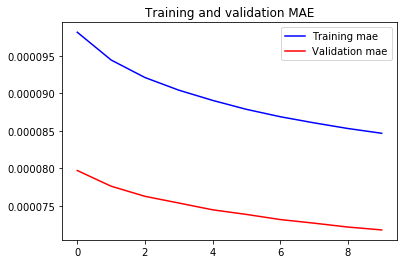

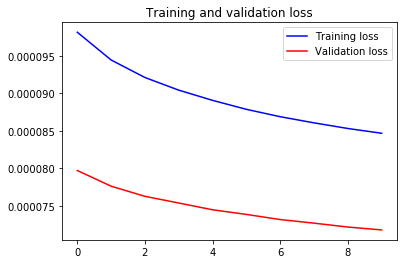

In [122]:
mae = history.history['mean_squared_error']
val_mae = history.history['val_mean_squared_error']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(mae))
 
plt.plot(epochs, mae, 'b', label='Training mae')
plt.plot(epochs, val_mae, 'r', label='Validation mae')
plt.title('Training and validation MAE')
plt.legend()
 
plt.show()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

vCanteen Mean Absolute Error: 16.0666666667
vCanteen Mean Square Error: 21.696389868670163
ShanghaiTech Mean Absolute Error: 50.4666666667
ShanghaiTech Mean Square Error: 54.95877242685345


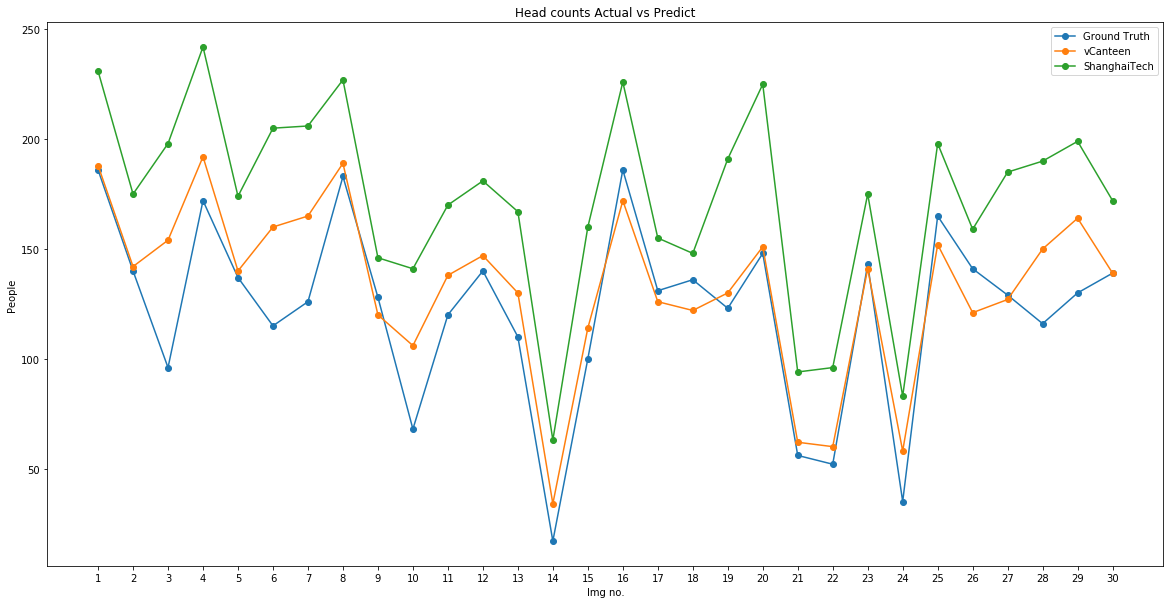

In [123]:
pred, sht_pred, ground_truth = test_model(model, ICANTEEN_TEST_GT_PATH)